In [1]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import lmfit
import emcee
import corner

saltire_dir = '/home/ADF/sebastdz/Documents/5Software/saltire'
sys.path.insert(0, os.path.abspath(saltire_dir))

import saltire

# Saltire - tutorial
This notebook will describe how to use Saltire to measure a cross correlation map
Compared to 1D CCF measurements, Saltire will take the full parameter space into account.

# 1.) Load data and setup the model

### Following information are needed to produce a full Saltire model:
| Array | Description |
| -------- | ----------------------------------------------------------------------------------------------------- |
| map_data | 2D array of CCFs                                                                                      |
| map_par  | K_p (semi amplitudes probed), vsys (systemic velocities probed)                                       |
| obs_part | times (time stemps of all included observations), weights (SNR or 1/variance of each observation)     |
| fixpar   | Orbital radial-velocity parameters, (period, Time of periaston, eccentricity, argument of periaston)  |


In [2]:
data_path   = 'tutorial_1'
output_path = 'results'



#read input data (see table above for description).
map_data = np.load(os.path.join(data_path,'map_data.npy'))
map_par  = np.load(os.path.join(data_path,'map_par.npy'),allow_pickle=True)
fixpar   = np.load(os.path.join(data_path,'fixpar.npy'))
obs_par  = np.load(os.path.join(data_path,'obs_comb.npy'),allow_pickle=True)

#define output path
outp = os.path.join(data_path,output_path)
#Check for output folder or create it
if os.path.exists(outp)==False:
    os.makedirs(outp)

In [3]:
####### Define CCF map ####### 
#data to be fitted
fit_data = map_data

#fit_err  = err[0]
#not used right now

#Specify range of semi-amplitudes of CCF map
K_p = map_par[0]

#Specify velocity range of CCF map
velo = map_par[1]

#Grid of map for fitting
x,y = np.meshgrid(velo,K_p)

In [4]:
###### Define orbit and observations ######

#Orbit parameters for model creation. This allows to use different orbit parameters for each call. 
#If one parameter set has been used, please still provide an array (filled with equal values) 

period = fixpar[0] #e.g. np.ones(len(K_p))*period
T0     = fixpar[1]
ecc    = fixpar[2]
omega  = fixpar[3]
fixpar = np.array([period,T0,ecc,omega])

In [5]:
#Other parameters for model creation

#Observing times of each datapoint used. 
obstimes = obs_par[0]

#Weighting. typically SNR of each observation 
weights = obs_par[1] #if not known: np.ones(len(obstimes))

planet=True #To fit the planet or the star. Ususally True, if it is the planet or secondary star (Note: The CCF map has to be specifically created for one case).

#pack parameters
obs = [obstimes,weights,planet]

In [6]:
###### Define fit parameters and ranges ######

K_start=77.      #Expected semi mayor axis of secondary [km/s]
v_start=32       #Expected systemin velocity [km/s]
sum_amp = -2e-4  #negative: Expected depth of CCF
dif_amp = -0.4   #negative: set close to 0, if no sidelobes are seen, close to -0.5, if clear sidelobes are seen.
sigmax1 =2.5     #Expected width of gaussian [km/s]
sigmax2 =8.8     #expected witdh of sidelobes [km/s], has to be larger than sigmax1 (independent from its amplitude).


params = lmfit.Parameters()
params.add('K', value=K_start, min = K_start-5.1,max = K_start+5.1)
params.add('v_sys', value=v_start, min = v_start-10,max = v_start+10)
params.add('height', value=1., min = 1-1e-4,max = 1+1e-4)
params.add('sum_amp', value=sum_amp, min = 0.2*sum_amp ,max = 3.5*sum_amp)
params.add('dif_amp', value=dif_amp, min = 1e-2 ,max = -0.49)
params.add('sigmax1', value=sigmax1, min = 0.5,max = 5)
params.add('sigmax2', value=sigmax2, min = sigmax1,max = 10) # sigmax1,max = 12)

###### define fitting function


#Uncomment to visually compare data and model
#arrar = saltire.fit_residual(params,x, y,obs=obs,fixpar=fixpar.T).reshape(len(K_p),len(velo))#,data=fit_data)
#saltire.plot_axis2D(velo,K_p,fit_data,savefig=False)
#saltire.plot_axis2D(velo,K_p,arrar,savefig=False)

# 2.) Run least square fit for best parameter estimate

In [7]:
# Run least square fitting for best parameters estimate
fit_result = saltire.saltirise(params=params,velo=velo,K_p=K_p,obs=obs,fixpar=fixpar,data=fit_data)

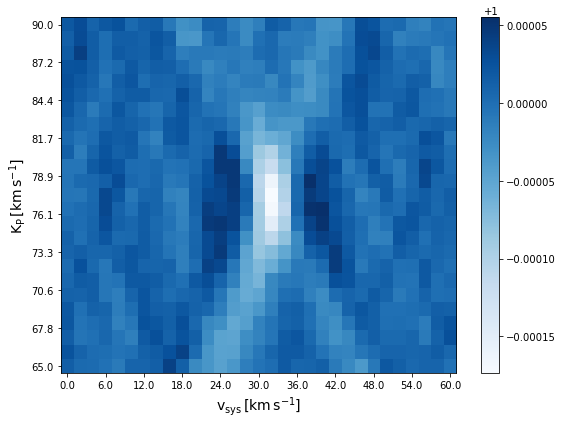

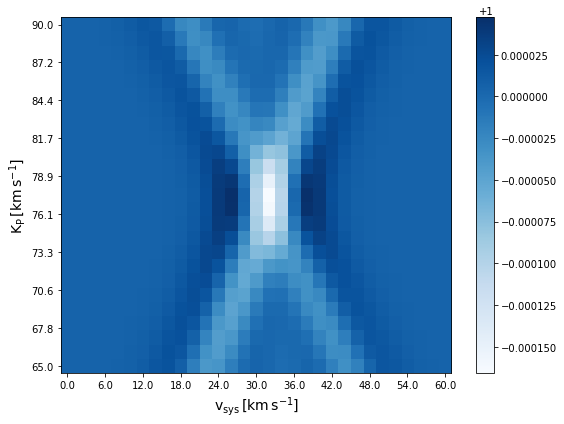

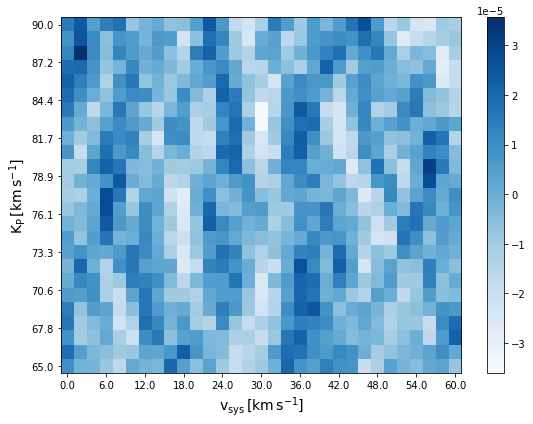

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 134
    # data points      = 775
    # variables        = 7
    chi-square         = 1.0891e-07
    reduced chi-square = 1.4181e-10
    Akaike info crit   = -17567.3177
    Bayesian info crit = -17534.7476
[[Variables]]
    K:        77.2062565 +/- 0.06344170 (0.08%) (init = 77)
    v_sys:    32.0358065 +/- 0.04818927 (0.15%) (init = 32)
    height:   1.00000531 +/- 6.5203e-07 (0.00%) (init = 1)
    sum_amp: -1.7182e-04 +/- 3.9799e-06 (2.32%) (init = -0.0002)
    dif_amp: -0.48999899 +/- 0.07846691 (16.01%) (init = -0.4)
    sigmax1:  2.74120173 +/- 0.15072378 (5.50%) (init = 2.5)
    sigmax2:  4.69304601 +/- 0.36999245 (7.88%) (init = 8.8)
[[Correlations]] (unreported correlations are < 0.100)
    C(dif_amp, sigmax1) = -0.951
    C(dif_amp, sigmax2) = 0.946
    C(sigmax1, sigmax2) = -0.817
    C(sum_amp, sigmax1) = 0.476
    C(height, sigmax2)  = -0.385
    C(sum_amp, dif_amp) = -0.310
    C(height, dif_amp) 

In [8]:
#show output
out  = saltire.fit_residual(fit_result.params,x, y,obs=obs,fixpar=fixpar.T,data=fit_data).reshape(len(K_p),len(velo))
fit  = saltire.fit_residual(fit_result.params,x, y,obs=obs,fixpar=fixpar.T).reshape(len(K_p),len(velo))#,data=fit_data)
saltire.plot_axis2D(velo,K_p,fit_data,savefig=False)
saltire.plot_axis2D(velo,K_p,fit,savefig=False)
saltire.plot_axis2D(velo,K_p,out,savefig=False)
lmfit.report_fit(fit_result)


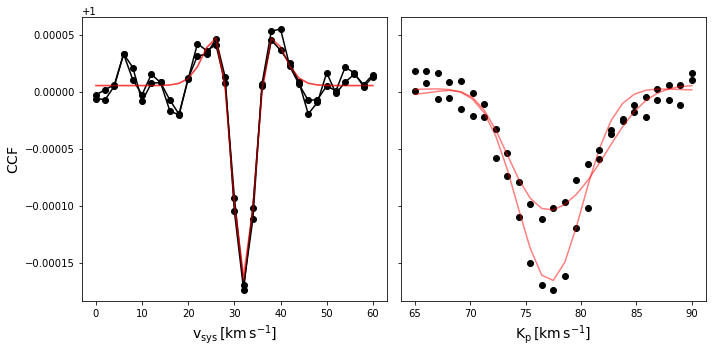

In [9]:
saltire.cutplot(fit_data,fit,velo,K_p,
                fit_result.params['v_sys'].value,
                fit_result.params['K'].value,
                file=os.path.join(outp,'lmfit_cut.png'),save=True,plotting=True,margin=1e-5)

In [10]:
# save fit report to a file:
orig_stdout = sys.stdout
f = open(os.path.join(outp,'lmfit_result.txt'), 'w')
sys.stdout = f

lmfit.report_fit(fit_result)

sys.stdout = orig_stdout
f.close()

# 3.) Run MCMC to derive uncertainies

In [11]:
# Create parameter file, based on best fit parameters
emcee_params = fit_result.params.copy()
emcee_params.add('jitter', value=1e-6, min=1e-8, max=1e-3)
emcee_params

name,value,standard error,relative error,initial value,min,max,vary
K,77.2062565,0.06344170,(0.08%),77.0,71.9000000,82.1000000,True
v_sys,32.0358065,0.04818927,(0.15%),32,22.0000000,42.0000000,True
height,1.00000531,6.5203e-07,(0.00%),1.0,0.99990000,1.00010000,True
sum_amp,-1.7182e-04,3.9799e-06,(2.32%),-0.0002,-7.0000e-04,-4.0000e-05,True
dif_amp,-0.48999899,0.07846691,(16.01%),-0.4,-0.49000000,0.01000000,True
sigmax1,2.74120173,0.15072378,(5.50%),2.5,0.50000000,5.00000000,True
sigmax2,4.69304601,0.36999245,(7.88%),8.8,2.50000000,10.0000000,True
jitter,1.0000e-06,,(7.88%),1e-06,1.0000e-08,1.0000e-03,True


In [12]:
#MCMC parameters
nwalkers = 42
nburnin  = 1500#00
nsteps   = 500#00
thin     = 5
n_threads= 15 #Multithreading - number of cores to use for the MCMC
savefile = os.path.join(outp,'save.h5')

#Initial step size on parameters for walkers.
e_p = [ 0.1, 0.1, 0.01, 1e-2, 0.001,0.1, 0.1, 1e-2]  #  K,v_sys,height,sum_amp,dif_amp,sigmax1,sigmax2,jitter

sampler,varnames = saltire.run_MCMC(params=emcee_params,x=x,y=y,e_p=e_p,obs=obs,fixpar=fixpar,data=fit_data,
                                    overwrite=True,filename = savefile,nwalkers=nwalkers,nburnin=nburnin,nsteps=nsteps,
                                    thin=thin,n_threads=n_threads)

Running burn-in ...


100%|███████████████████████████████████████| 1500/1500 [03:11<00:00,  7.82it/s]


Running sampler ...


100%|███████████████████████████████████████| 2500/2500 [05:38<00:00,  7.39it/s]


### The result is an emcee sampler. 
Please refer to the documentation of emcee for further details on how to explore these.
https://emcee.readthedocs.io/en/stable/user/sampler/

### If MCMC has been completed or saved, simply read the save file
```
reader = emcee.backends.HDFBackend(savefile, read_only=True)
chain = reader.get_chain()
```

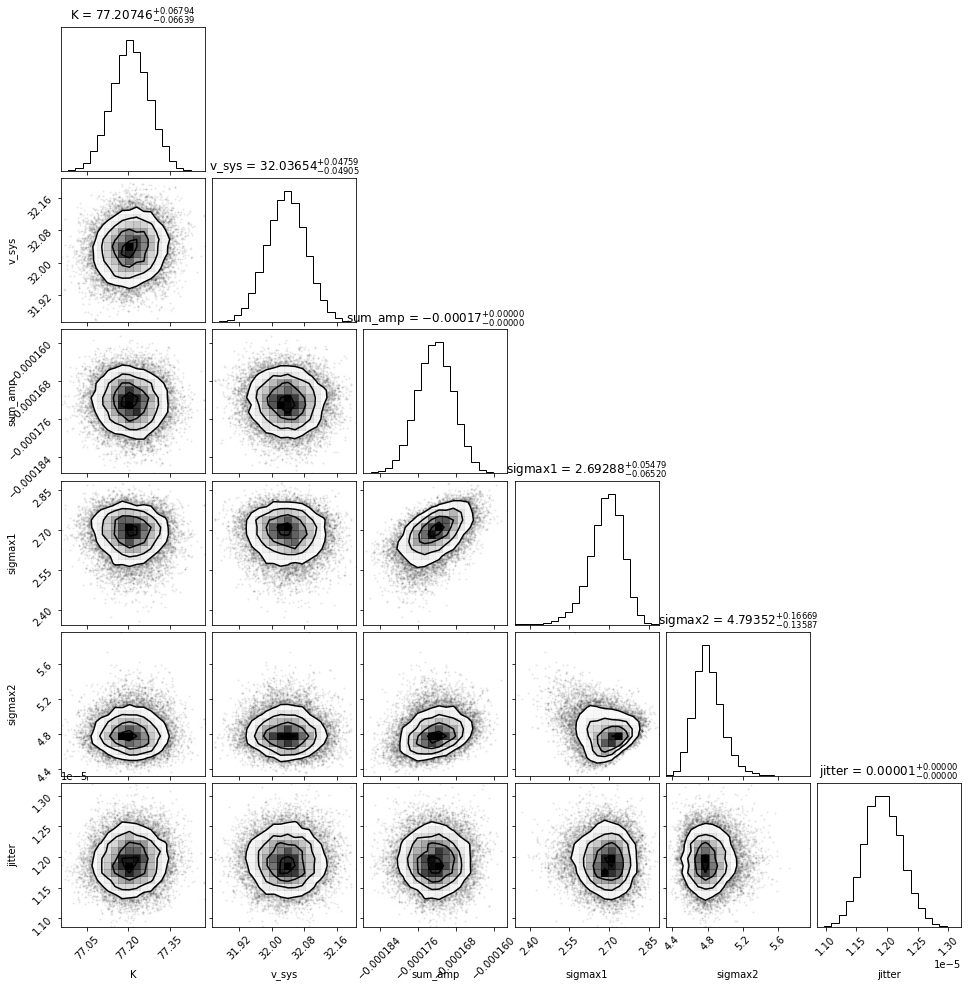

In [13]:
#create and save a cornerplot

part=np.array([0,1,3,5,6,7])
flat_samples = sampler.get_chain(flat=True)
emcee_plot = corner.corner(flat_samples.T[part].T, labels=np.array(varnames)[part],
                    show_titles=True,title_fmt='.5f')#, labels=['K','v_sys','sum_amp','sigmax1','sigmax2','__lnsigma'])
plt.savefig(os.path.join(outp,'MCMC_contour.png'))

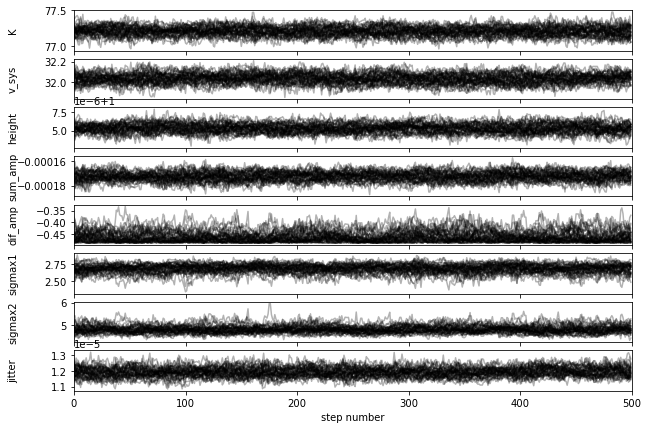

In [14]:
#plot chains

fig, axes = plt.subplots(len(varnames), figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = varnames
for i in range(len(varnames)):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Sigma = 14.46 +/- 0.48


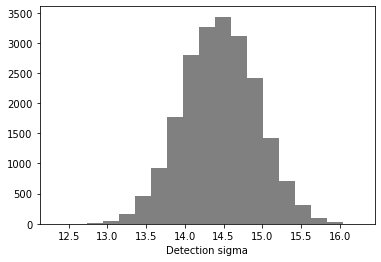

In [15]:
#Derive statistical detection
noise  = flat_samples[:,7] #jitter
signal = flat_samples[:,3] #sum_amplitude
snr    = np.abs(signal)/noise
sigma = np.percentile(snr,[15.8655, 50, 84.1345])
print("Sigma = {:.2f} +/- {:.2f}".format(sigma[1],(sigma[2]-sigma[0])/2))
plt.hist(snr,bins=np.linspace(np.min(snr),np.max(snr),20),color='gray')
plt.xlabel('Detection sigma')
plt.show()


In [16]:
qK = np.percentile(flat_samples[:,0],[15.8655, 50, 84.1345])
qvsys = np.percentile(flat_samples[:,1],[15.8655, 50, 84.1345])
qheight = np.percentile(flat_samples[:,2],[15.8655, 50, 84.1345])

qsum_amp = np.percentile(flat_samples[:,3],[15.8655, 50, 84.1345])
qdif_amp = np.percentile(flat_samples[:,4],[15.8655, 50, 84.1345])

qsigmax1 = np.percentile(flat_samples[:,5],[15.8655, 50, 84.1345])
qsigmax2 = np.percentile(flat_samples[:,6],[15.8655, 50, 84.1345])
qjitter = np.percentile(flat_samples[:,7],[15.8655, 50, 84.1345])

print("K_s = {:.4f} +/- {:.4f}".format(qK[1],(qK[2]-qK[0])/2))
print("v_sys = {:.4f} +/- {:.4f}".format(qvsys[1],(qvsys[2]-qvsys[0])/2))
print("heigth = {:.6f} +/- {:.6f}".format(qheight[1],(qheight[2]-qheight[0])/2))
print("sum_amp = {:.6f} +/- {:.6f}".format(qsum_amp[1],(qsum_amp[2]-qsum_amp[0])/2))
print("jitter  = {:.8f} +/- {:.8f}".format(qjitter[1],(qjitter[2]-qjitter[0])/2))

K_s = 77.2075 +/- 0.0676
v_sys = 32.0365 +/- 0.0486
heigth = 1.000005 +/- 0.000001
sum_amp = -0.000172 +/- 0.000004
jitter  = 0.00001193 +/- 0.00000030


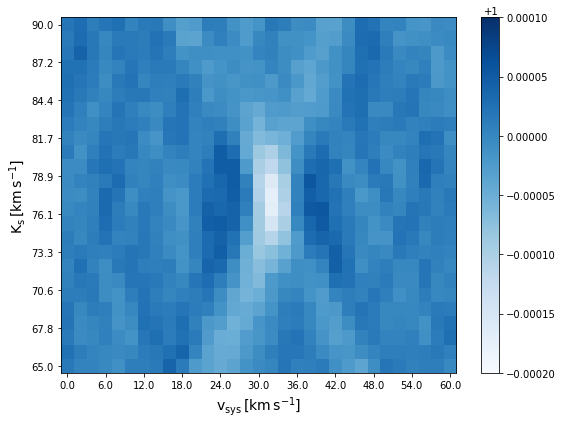

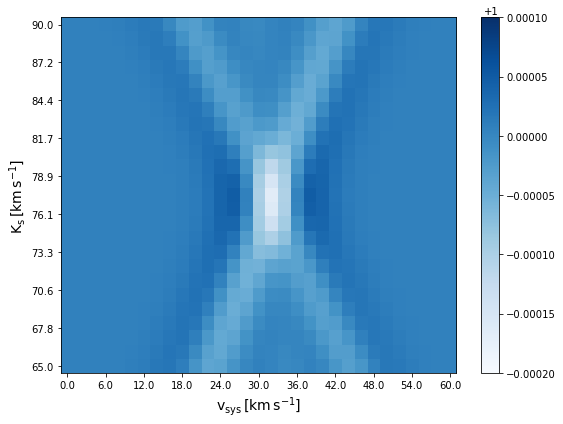

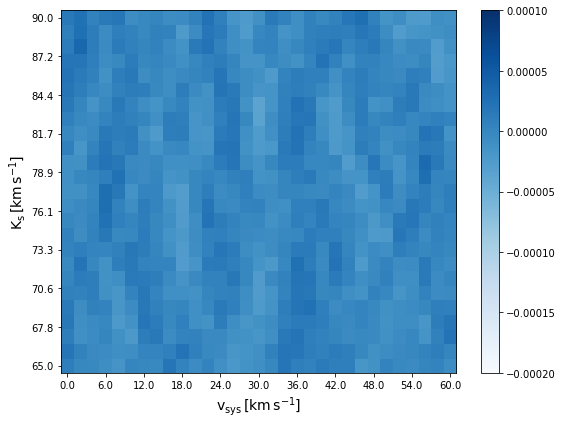

name,value,standard error,relative error,initial value,min,max,vary
K,77.2074650,0.06756434,(0.09%),77.0,71.9000000,82.1000000,True
v_sys,32.0365449,0.04855085,(0.15%),32,22.0000000,42.0000000,True
height,1.00000532,6.3119e-07,(0.00%),1.0,0.99990000,1.00010000,True
sum_amp,-1.7237e-04,3.8465e-06,(2.23%),-0.0002,-7.0000e-04,-4.0000e-05,True
dif_amp,-0.46943589,0.02192274,(4.67%),-0.4,-0.49000000,0.01000000,True
sigmax1,2.69288181,0.06030902,(2.24%),2.5,0.50000000,5.00000000,True
sigmax2,4.79352382,0.15230883,(3.18%),8.8,2.50000000,10.0000000,True


In [17]:
#plot MCMC results
MCMC_res_params = fit_result.params.copy()
res_vals = [qK[1],qvsys[1],qheight[1],qsum_amp[1],qdif_amp[1],qsigmax1[1],qsigmax2[1]]
res_err  = [(qK[2]-qK[0])/2,(qvsys[2]-qvsys[0])/2,(qheight[2]-qheight[0])/2,(qsum_amp[2]-qsum_amp[0])/2,
            (qdif_amp[2]-qdif_amp[0])/2,(qsigmax1[2]-qsigmax1[0])/2,(qsigmax2[2]-qsigmax2[0])/2]
for i,p in enumerate(MCMC_res_params):
    if MCMC_res_params[p].vary:
        MCMC_res_params[p].value = res_vals[i]
        MCMC_res_params[p].stderr = res_err[i]

MCMC_res_params#['K'].stderr
#evaluate model
arrar = saltire.fit_residual(MCMC_res_params,x, y,obs=obs,fixpar=fixpar.T).reshape(len(K_p),len(velo))#,data=fit_data)
saltire.plot_axis2D(velo,K_p,fit_data,ylabel='K_{s}\,[km\,s^{-1}]',       outim=os.path.join(outp,'MCMC_01_data.png'     ),vmin=1-2e-4,vmax=1+1e-4,savefig=True)
saltire.plot_axis2D(velo,K_p,arrar,   ylabel='K_{s}\,[km\,s^{-1}]',       outim=os.path.join(outp,'MCMC_02_fit.png'      ),vmin=1-2e-4,vmax=1+1e-4,savefig=True)
saltire.plot_axis2D(velo,K_p,fit_data-arrar,ylabel='K_{s}\,[km\,s^{-1}]', outim=os.path.join(outp,'MCMC_03_residuals.png'),vmin=0-2e-4,vmax=0+1e-4,savefig=True)
MCMC_res_params

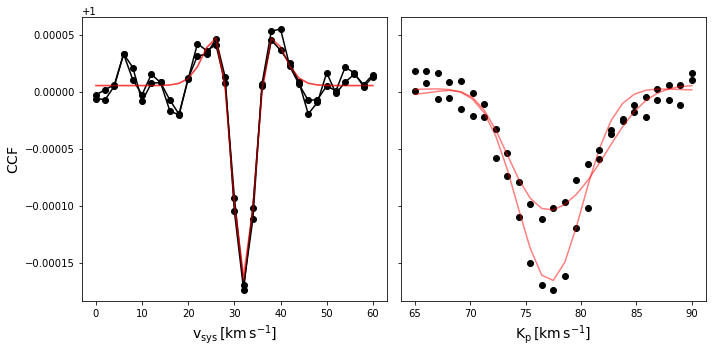

In [18]:
saltire.cutplot(fit_data,fit,velo,K_p,
                MCMC_res_params['v_sys'].value,
                MCMC_res_params['K'].value,
                file=os.path.join(outp,'MCMC_04_cut.png'),save=True,plotting=True,margin=1e-5)